In [119]:
##########################################
# Fama French 3 Factors                  #
# Qingyi (Freda) Song Drechsler          #
# Date: April 2018                       #
# Updated: June 2020                     #
##########################################

import pandas as pd
import numpy as np
import datetime as dt
import wrds
#import psycopg2 
import matplotlib.pyplot as plt
from dateutil.relativedelta import *
from pandas.tseries.offsets import *
from scipy import stats
import warnings

In [120]:
###################
# Connect to WRDS #
###################
conn=wrds.Connection()

Loading library list...
Done


In [121]:
###################
# Compustat Block #
###################
comp = conn.raw_sql("""
                    select gvkey, datadate, at, pstkl, txditc,
                    pstkrv, seq, pstk
                    from comp.funda
                    where indfmt='INDL' 
                    and datafmt='STD'
                    and popsrc='D'
                    and consol='C'
                    and datadate >= '01/01/1925'
                    """, date_cols=['datadate'])

comp['year']=comp['datadate'].dt.year

In [122]:
# create preferrerd stock
comp['ps']=np.where(comp['pstkrv'].isnull(), comp['pstkl'], comp['pstkrv'])
comp['ps']=np.where(comp['ps'].isnull(),comp['pstk'], comp['ps'])
comp['ps']=np.where(comp['ps'].isnull(),0,comp['ps'])
comp['txditc']=comp['txditc'].fillna(0)

In [123]:
# create book equity
comp['be']=comp['seq']+comp['txditc']-comp['ps']
comp['be']=np.where(comp['be']>0, comp['be'], np.nan)

In [124]:
# number of years in Compustat
comp=comp.sort_values(by=['gvkey','datadate'])
comp['count']=comp.groupby(['gvkey']).cumcount()

comp=comp[['gvkey','datadate','year','be','count']]

In [125]:
comp

,gvkey,datadate,year,be,count
0,001000,1961-12-31,1961,NaN,0
1,001000,1962-12-31,1962,NaN,1
2,001000,1963-12-31,1963,0.561,2
3,001000,1964-12-31,1964,0.627,3
4,001000,1965-12-31,1965,0.491,4
...,...,...,...,...,...
69012,353945,2021-12-31,2021,305.149,0
69013,353945,2022-12-31,2022,316.595,1
69014,354003,2023-12-31,2023,NaN,0
69015,356128,2022-12-31,2022,1778.026,0


In [126]:
###################
# CRSP Block      #
###################
# sql similar to crspmerge macro
crsp_m = conn.raw_sql("""
                      select a.permno, a.permco, a.date, b.shrcd, b.exchcd,
                      a.ret, a.retx, a.shrout, a.prc
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/1924' and '12/31/2023'
                      and b.exchcd between 1 and 3
                      """, date_cols=['date']) 

# change variable format to int
crsp_m[['permco','permno','shrcd','exchcd']]=crsp_m[['permco','permno','shrcd','exchcd']].astype(int)

# Line up date to be end of month
crsp_m['jdate']=crsp_m['date']+MonthEnd(0)

In [127]:
# add delisting return
dlret = conn.raw_sql("""
                     select permno, dlret, dlstdt 
                     from crsp.msedelist
                     """, date_cols=['dlstdt'])

dlret.permno=dlret.permno.astype(int)
#dlret['dlstdt']=pd.to_datetime(dlret['dlstdt'])
dlret['jdate']=dlret['dlstdt']+MonthEnd(0)

crsp = pd.merge(crsp_m, dlret, how='left',on=['permno','jdate'])
crsp['dlret']=crsp['dlret'].fillna(0)
crsp['ret']=crsp['ret'].fillna(0)

# retadj factors in the delisting returns
crsp['retadj']=(1+crsp['ret'])*(1+crsp['dlret'])-1

# calculate market equity
crsp['me']=crsp['prc'].abs()*crsp['shrout'] 
crsp=crsp.drop(['dlret','dlstdt','prc','shrout'], axis=1)
crsp=crsp.sort_values(by=['jdate','permco','me'])

In [128]:
### Aggregate Market Cap ###
# sum of me across different permno belonging to same permco a given date
crsp_summe = crsp.groupby(['jdate','permco'])['me'].sum().reset_index()

# largest mktcap within a permco/date
crsp_maxme = crsp.groupby(['jdate','permco'])['me'].max().reset_index()

# join by jdate/maxme to find the permno
crsp1=pd.merge(crsp, crsp_maxme, how='inner', on=['jdate','permco','me'])

# drop me column and replace with the sum me
crsp1=crsp1.drop(['me'], axis=1)

# join with sum of me to get the correct market cap info
crsp2=pd.merge(crsp1, crsp_summe, how='inner', on=['jdate','permco'])

# sort by permno and date and also drop duplicates
crsp2=crsp2.sort_values(by=['permno','jdate']).drop_duplicates()


In [129]:
# keep December market cap
crsp2['year']=crsp2['jdate'].dt.year
crsp2['month']=crsp2['jdate'].dt.month
decme=crsp2[crsp2['month']==12]
decme=decme[['permno','date','jdate','me','year']].rename(columns={'me':'dec_me'})

### July to June dates
crsp2['ffdate']=crsp2['jdate']+MonthEnd(-6)
crsp2['ffyear']=crsp2['ffdate'].dt.year
crsp2['ffmonth']=crsp2['ffdate'].dt.month
crsp2['1+retx']=1+crsp2['retx']
crsp2=crsp2.sort_values(by=['permno','date'])

In [130]:
# cumret by stock
crsp2['cumretx']=crsp2.groupby(['permno','ffyear'])['1+retx'].cumprod()

# lag cumret
crsp2['lcumretx']=crsp2.groupby(['permno'])['cumretx'].shift(1)

# lag market cap
crsp2['lme']=crsp2.groupby(['permno'])['me'].shift(1)

# if first permno then use me/(1+retx) to replace the missing value
crsp2['count']=crsp2.groupby(['permno']).cumcount()
crsp2['lme']=np.where(crsp2['count']==0, crsp2['me']/crsp2['1+retx'], crsp2['lme'])

# baseline me
mebase=crsp2[crsp2['ffmonth']==1][['permno','ffyear', 'lme']].rename(columns={'lme':'mebase'})

# merge result back together
crsp3=pd.merge(crsp2, mebase, how='left', on=['permno','ffyear'])
crsp3['wt']=np.where(crsp3['ffmonth']==1, crsp3['lme'], crsp3['mebase']*crsp3['lcumretx'])

decme['year']=decme['year']+1
decme=decme[['permno','year','dec_me']]

In [131]:
# Info as of June
crsp3_jun = crsp3[crsp3['month']==6]

crsp_jun = pd.merge(crsp3_jun, decme, how='inner', on=['permno','year'])
crsp_jun=crsp_jun[['permno','date', 'jdate', 'shrcd','exchcd','retadj','me','wt','cumretx','mebase','lme','dec_me']]
crsp_jun=crsp_jun.sort_values(by=['permno','jdate']).drop_duplicates()

In [132]:
#######################
# CCM Block           #
#######################
ccm=conn.raw_sql("""
                  select gvkey, lpermno as permno, linktype, linkprim, 
                  linkdt, linkenddt
                  from crsp.ccmxpf_linktable
                  where substr(linktype,1,1)='L'
                  and (linkprim ='C' or linkprim='P')
                  """, date_cols=['linkdt', 'linkenddt'])

# if linkenddt is missing then set to today date
ccm['linkenddt']=ccm['linkenddt'].fillna(pd.to_datetime('today'))

ccm1=pd.merge(comp[['gvkey','datadate','be', 'count']],ccm,how='left',on=['gvkey'])
ccm1['yearend']=ccm1['datadate']+YearEnd(0)
ccm1['jdate']=ccm1['yearend']+MonthEnd(6)

In [133]:
# set link date bounds
ccm2=ccm1[(ccm1['jdate']>=ccm1['linkdt'])&(ccm1['jdate']<=ccm1['linkenddt'])]
ccm2=ccm2[['gvkey','permno','datadate','yearend', 'jdate','be', 'count']]

In [134]:
ccm2

,gvkey,permno,datadate,yearend,jdate,be,count
9,001000,25881.0,1970-12-31,1970-12-31,1971-06-30,10.544,9
10,001000,25881.0,1971-12-31,1971-12-31,1972-06-30,8.382,10
11,001000,25881.0,1972-12-31,1972-12-31,1973-06-30,7.309,11
12,001000,25881.0,1973-12-31,1973-12-31,1974-06-30,8.798,12
13,001000,25881.0,1974-12-31,1974-12-31,1975-06-30,8.279,13
...,...,...,...,...,...,...,...
679209,350681,22205.0,2021-12-31,2021-12-31,2022-06-30,596.490,1
679212,351038,16161.0,2021-12-31,2021-12-31,2022-06-30,0.657,2
679213,351038,16161.0,2022-12-31,2022-12-31,2023-06-30,7.407,3
679223,352262,23773.0,2022-12-31,2022-12-31,2023-06-30,646.557,0


In [135]:
historical_ff_data = pd.read_csv("DFF_BE_With_Nonindust_Cleaned.csv")
historical_ff_data = historical_ff_data.drop('Unnamed: 0', axis = 1)
historical_ff_data['datadate'] = pd.to_datetime(historical_ff_data['datadate'])
historical_ff_data['yearend'] = pd.to_datetime(historical_ff_data['yearend'])
historical_ff_data['jdate'] = pd.to_datetime(historical_ff_data['jdate'])
historical_ff_data

,permno,datadate,yearend,jdate,be,count
0,10006,1925-12-31,1925-12-31,1926-06-30,67.743,1
1,10006,1926-12-31,1926-12-31,1927-06-30,71.245,2
2,10006,1927-12-31,1927-12-31,1928-06-30,70.139,3
3,10006,1928-12-31,1928-12-31,1929-06-30,70.139,4
4,10006,1929-12-31,1929-12-31,1930-06-30,70.139,5
...,...,...,...,...,...,...
29807,86239,1972-12-31,1972-12-31,1973-06-30,165.883,37
29808,86239,1973-12-31,1973-12-31,1974-06-30,168.391,38
29809,86861,1997-12-31,1997-12-31,1998-06-30,426.523,1
29810,92567,1988-12-31,1988-12-31,1989-06-30,941.791,1


In [136]:
unique_permno = list(ccm2['permno'].unique())
permno_gvkey = {}
for i in range(0, len(unique_permno)):
    temp = ccm2.loc[ccm2['permno'] == unique_permno[i], 'gvkey']
    if not temp.empty:
        gvkey = temp.iloc[0]
        permno_gvkey[unique_permno[i]] = gvkey
np.save('permno_gvkey_dictionary.npy', permno_gvkey)

In [137]:
historical_ff_data_with_gvkey = pd.read_csv("DFF_BE_With_Nonindust_Cleaned_with_gvkey.csv")
historical_ff_data_with_gvkey = historical_ff_data_with_gvkey.drop('Unnamed: 0', axis = 1)
historical_ff_data_with_gvkey['datadate'] = pd.to_datetime(historical_ff_data_with_gvkey['datadate'])
historical_ff_data_with_gvkey['yearend'] = pd.to_datetime(historical_ff_data_with_gvkey['yearend'])
historical_ff_data_with_gvkey['jdate'] = pd.to_datetime(historical_ff_data_with_gvkey['jdate'])

In [138]:
ccm2_merged = pd.concat([historical_ff_data_with_gvkey, ccm2], ignore_index=True, axis=0)
#ccm2_merged.be_x.fillna(ccm2_merged.be_y, inplace=True)
#ccm2_merged = ccm2_merged.drop(['be_y', 'count_y'], axis = 1)
#ccm2_merged = ccm2_merged.rename({'be_x': 'be', 'count_x': 'count'}, axis='columns')
ccm2_merged = ccm2_merged.sort_values(by=['permno','jdate']).drop_duplicates()

In [139]:
# link comp and crsp
ccm_jun=pd.merge(crsp_jun, ccm2_merged, how='inner', on=['permno', 'jdate'])
ccm_jun['beme']=ccm_jun['be']*1000/ccm_jun['dec_me']

In [140]:
warnings.filterwarnings('ignore')

# select NYSE stocks for bucket breakdown
# exchcd = 1 and positive beme and positive me and shrcd in (10,11) and at least 2 years in comp
nyse=ccm_jun[(ccm_jun['exchcd']==1) & (ccm_jun['beme']>0) & (ccm_jun['me']>0) & \
            ((ccm_jun['shrcd']==10) | (ccm_jun['shrcd']==11))]

# size breakdown
nyse_sz=nyse.groupby(['jdate'])['me'].median().to_frame().reset_index().rename(columns={'me':'sizemedn'})

# beme breakdown
nyse_bm=nyse.groupby(['jdate'])['beme'].describe(percentiles=[0.3, 0.7]).reset_index()
nyse_bm=nyse_bm[['jdate','30%','70%']].rename(columns={'30%':'bm30', '70%':'bm70'})

nyse_breaks = pd.merge(nyse_sz, nyse_bm, how='inner', on=['jdate'])

# join back size and beme breakdown
ccm1_jun = pd.merge(ccm_jun, nyse_breaks, how='left', on=['jdate'])

In [141]:
ccm1_jun.sort_values(by = 'jdate').head(500)

,permno,date,jdate,shrcd,exchcd,retadj,me,wt,cumretx,mebase,...,dec_me,gvkey,datadate,yearend,be,count,beme,sizemedn,bm30,bm70
29015,12562,1926-06-30,1926-06-30,10,1,0.016881,4731.3125,NaN,0.871488,NaN,...,5429.00,6113,1925-12-31,1925-12-31,8.354,1,1.538773,14290.65625,0.709718,1.563609
49666,15368,1926-06-30,1926-06-30,11,1,0.040892,158010.0000,NaN,0.930859,NaN,...,169746.25,11436,1925-12-31,1925-12-31,166.220,1,0.979226,14290.65625,0.709718,1.563609
15908,11367,1926-06-30,1926-06-30,10,1,-0.017241,16128.0000,NaN,0.601937,NaN,...,22740.00,3206,1925-12-31,1925-12-31,12.163,1,0.534872,14290.65625,0.709718,1.563609
36242,13653,1926-06-30,1926-06-30,10,1,0.005236,4800.0000,NaN,0.932039,NaN,...,0.00,8204,1925-12-31,1925-12-31,3.502,1,inf,14290.65625,0.709718,1.563609
45114,14760,1926-06-30,1926-06-30,10,1,0.074681,92075.0000,NaN,1.198346,NaN,...,76835.00,10510,1925-12-31,1925-12-31,13.590,1,0.176873,14290.65625,0.709718,1.563609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13589,11148,1927-06-30,1927-06-30,10,1,0.002381,90515.0000,89249.897489,1.275756,70125.00,...,74551.25,10021,1926-12-31,1926-12-31,70.715,2,0.948542,15850.00000,0.799895,1.571101
50446,15472,1927-06-30,1927-06-30,11,1,-0.023148,94500.0000,97199.840578,0.999998,94500.00,...,92700.00,11609,1926-12-31,1926-12-31,34.911,2,0.376602,15850.00000,0.799895,1.571101
52117,15720,1927-06-30,1927-06-30,11,1,-0.014440,65281.1250,62309.000357,1.099544,55849.75,...,55849.75,9846,1926-12-31,1926-12-31,47.652,1,0.853218,15850.00000,0.799895,1.571101
1769,10145,1927-06-30,1927-06-30,11,1,-0.036269,303831.0000,315265.325710,1.137615,267077.25,...,296480.25,1300,1926-12-31,1926-12-31,172.804,2,0.582852,15850.00000,0.799895,1.571101


In [142]:
bm70_time_series = ccm1_jun.groupby('jdate')['bm70'].mean()
bm30_time_series = ccm1_jun.groupby('jdate')['bm30'].mean()

In [143]:
bm30_time_series

jdate
1926-06-30    0.709718
1927-06-30    0.799895
1928-06-30    0.637935
1929-06-30    0.468505
1930-06-30    0.700125
                ...   
2019-06-30    0.352840
2020-06-30    0.310771
2021-06-30    0.265446
2022-06-30    0.240185
2023-06-30    0.322336
Name: bm30, Length: 98, dtype: float64

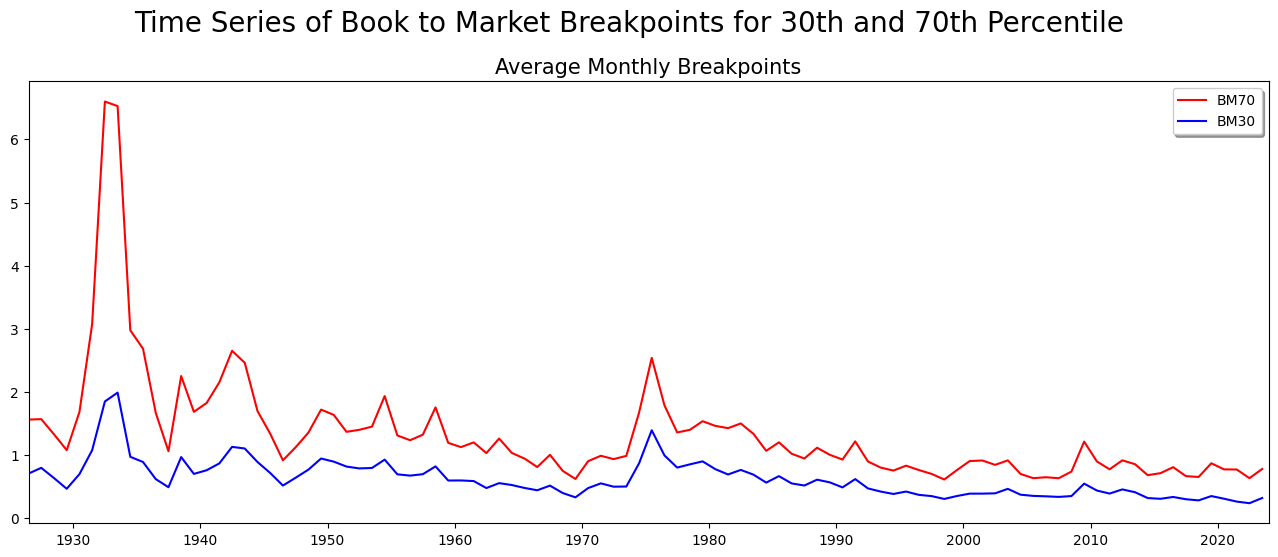

In [144]:
plt.figure(figsize=(16,12))
plt.suptitle('Time Series of Book to Market Breakpoints for 30th and 70th Percentile', fontsize=20)

ax1 = plt.subplot(211)
ax1.set_title('Average Monthly Breakpoints', fontsize=15)
ax1.set_xlim([dt.datetime(1926,7,1), dt.datetime(2023,12,31)])
ax1.plot(bm70_time_series, 'r-', bm30_time_series, 'b-')
ax1.legend(('BM70','BM30'), loc='upper right', shadow=True)

plt.subplots_adjust(top=0.92, hspace=0.2)

plt.show()

In [145]:
ff_breakpoints = pd.read_csv("BE-ME_Breakpoints.csv", skiprows=3, header=None)
ff_breakpoints.drop(ff_breakpoints.tail(1).index,inplace=True)
ff_breakpoints = ff_breakpoints.rename({0: 'year', 3: 'bm5', 4: 'bm10', 5: 'bm15', 6: 'bm20', 7: 'bm25', 8: 'bm30', 9: 'bm35', 10: 'bm40',
                                       11: 'bm45', 12: 'bm50', 13: 'bm55', 14: 'bm60', 15: 'bm65', 16: 'bm70', 17: 'bm75', 18: 'bm80',
                                       19: 'bm85', 20: 'bm90', 21: 'bm95', 22: 'bm100'}, axis='columns')
ff_breakpoints['year'] = pd.to_datetime(ff_breakpoints['year']) + pd.DateOffset(months=6)
ff_breakpoints.set_index('year', inplace=True)
ff_breakpoints

,1,2,bm5,bm10,bm15,bm20,bm25,bm30,bm35,bm40,...,bm55,bm60,bm65,bm70,bm75,bm80,bm85,bm90,bm95,bm100
year,,,,,,,,,,,,,,,,,,,,,
1926-07-01,3.0,429.0,0.296,0.404,0.491,0.595,0.660,0.705,0.790,0.863,...,1.094,1.254,1.376,1.539,1.779,2.027,2.456,3.381,5.851,31.322
1927-07-01,1.0,464.0,0.320,0.427,0.537,0.627,0.682,0.783,0.866,0.933,...,1.146,1.234,1.363,1.554,1.829,2.205,2.693,3.483,5.010,53.102
1928-07-01,1.0,486.0,0.209,0.335,0.404,0.472,0.549,0.628,0.675,0.740,...,0.974,1.062,1.185,1.308,1.499,1.694,2.021,2.571,4.263,25.054
1929-07-01,5.0,519.0,0.167,0.230,0.311,0.367,0.414,0.468,0.531,0.569,...,0.752,0.838,0.941,1.056,1.184,1.399,1.650,2.235,3.294,38.578
1930-07-01,3.0,589.0,0.286,0.378,0.458,0.556,0.628,0.705,0.789,0.866,...,1.161,1.288,1.446,1.664,1.966,2.270,3.040,4.442,7.629,126.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-01,74.0,1110.0,0.087,0.138,0.186,0.231,0.282,0.327,0.383,0.430,...,0.575,0.654,0.715,0.802,0.908,1.004,1.156,1.335,1.862,24.160
2020-07-01,73.0,1071.0,0.074,0.120,0.161,0.205,0.242,0.288,0.326,0.368,...,0.510,0.570,0.648,0.710,0.787,0.880,1.031,1.259,1.753,35.413
2021-07-01,71.0,1067.0,0.048,0.093,0.132,0.165,0.207,0.245,0.281,0.331,...,0.480,0.542,0.618,0.698,0.795,0.894,1.028,1.234,1.726,13.605


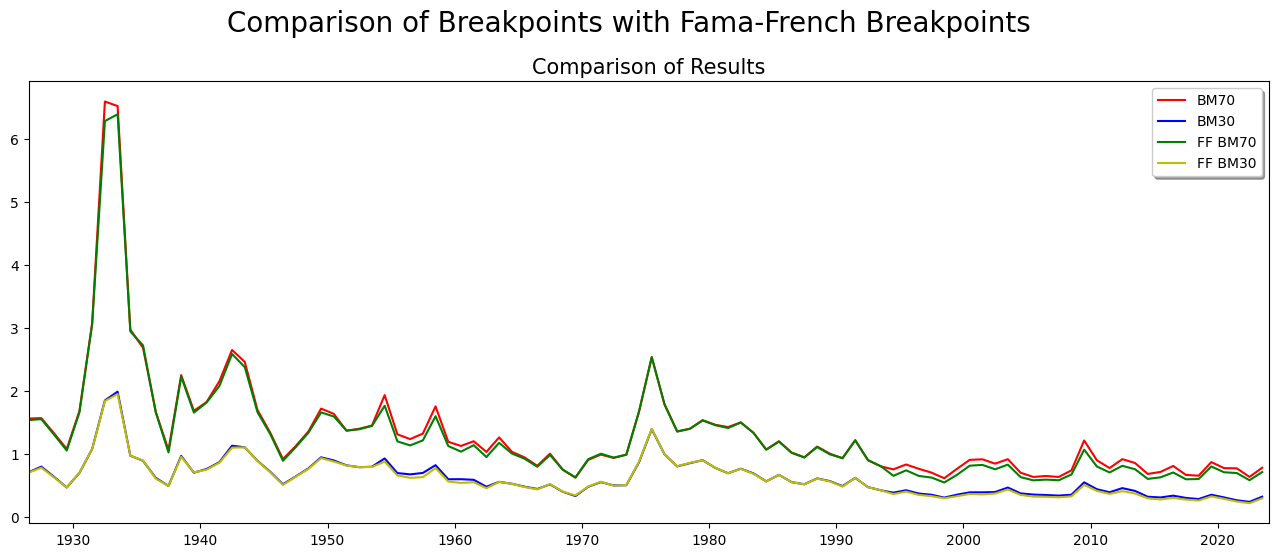

In [146]:
plt.figure(figsize=(16,12))
plt.suptitle('Comparison of Breakpoints with Fama-French Breakpoints', fontsize=20)

ax1 = plt.subplot(211)
ax1.set_title('Comparison of Results', fontsize=15)
ax1.set_xlim([dt.datetime(1926,7,1), dt.datetime(2023,12,31)])
ax1.plot(bm70_time_series, 'r-', bm30_time_series, 'b-', ff_breakpoints['bm70'], 'g-', ff_breakpoints['bm30'], 'y-')
ax1.legend(('BM70','BM30', 'FF BM70', 'FF BM30'), loc='upper right', shadow=True)

plt.subplots_adjust(top=0.92, hspace=0.2)

plt.show()

In [147]:
# function to assign sz and bm bucket
def sz_bucket(row):
    if row['me']==np.nan:
        value=''
    elif row['me']<=row['sizemedn']:
        value='S'
    else:
        value='B'
    return value

def bm_bucket(row):
    if 0<=row['beme']<=row['bm30']:
        value = 'L'
    elif row['beme']<=row['bm70']:
        value='M'
    elif row['beme']>row['bm70']:
        value='H'
    else:
        value=''
    return value


In [148]:
# assign size portfolio
ccm1_jun['szport']=np.where((ccm1_jun['beme']>0)&(ccm1_jun['me']>0)&(ccm1_jun['count']>=1), ccm1_jun.apply(sz_bucket, axis=1), '')

# assign book-to-market portfolio
ccm1_jun['bmport']=np.where((ccm1_jun['beme']>0)&(ccm1_jun['me']>0)&(ccm1_jun['count']>=1), ccm1_jun.apply(bm_bucket, axis=1), '')
ccm1_jun.sort_values(by = 'jdate').head(500)

# create positivebmeme and nonmissport variable
ccm1_jun['posbm']=np.where((ccm1_jun['beme']>0)&(ccm1_jun['me']>0)&(ccm1_jun['count']>=1), 1, 0)
ccm1_jun['nonmissport']=np.where((ccm1_jun['bmport']!=''), 1, 0)

In [149]:

# store portfolio assignment as of June
june=ccm1_jun[['permno','date', 'jdate', 'bmport','szport','posbm','nonmissport']]
june['ffyear']=june['jdate'].dt.year

# merge back with monthly records
crsp3 = crsp3[['date','permno','shrcd','exchcd','retadj','me','wt','cumretx','ffyear','jdate']]
ccm3=pd.merge(crsp3, 
        june[['permno','ffyear','szport','bmport','posbm','nonmissport']], how='left', on=['permno','ffyear'])

# keeping only records that meet the criteria
ccm4=ccm3[(ccm3['wt']>0)& (ccm3['posbm']==1) & (ccm3['nonmissport']==1) & 
          ((ccm3['shrcd']==10) | (ccm3['shrcd']==11))]

ccm5=ccm3[(ccm3['wt']>0) &
          ((ccm3['shrcd']==10) | (ccm3['shrcd']==11))]

In [28]:
stdev_monthly_returns = ccm5.groupby('date')['retadj'].std()

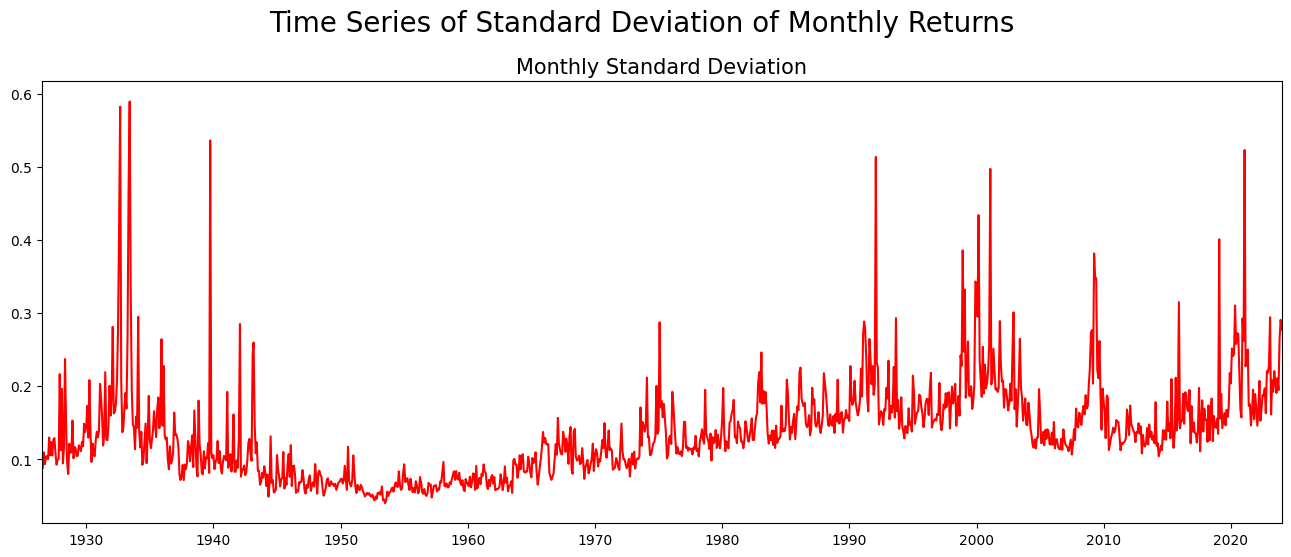

In [66]:
plt.figure(figsize=(16,12))
plt.suptitle('Time Series of Standard Deviation of Monthly Returns', fontsize=20)

ax1 = plt.subplot(211)
ax1.set_title('Monthly Standard Deviation', fontsize=15)
ax1.set_xlim([dt.datetime(1926,7,1), dt.datetime(2023,12,31)])
ax1.plot(stdev_monthly_returns, 'r-')

plt.subplots_adjust(top=0.92, hspace=0.2)

plt.show()

In [30]:
############################
# Form Fama French Factors #
############################

# function to calculate value weighted return
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan

In [31]:

# value-weigthed return
vwret=ccm5.groupby(['jdate','szport','bmport']).apply(wavg, 'retadj','wt').to_frame().reset_index().rename(columns={0: 'vwret'})
vwret['sbport']=vwret['szport']+vwret['bmport']

# firm count
vwret_n=ccm5.groupby(['jdate','szport','bmport'])['retadj'].count().reset_index().rename(columns={'retadj':'n_firms'})
vwret_n['sbport']=vwret_n['szport']+vwret_n['bmport']

# tranpose
ff_factors=vwret.pivot(index='jdate', columns='sbport', values='vwret').reset_index()
ff_nfirms=vwret_n.pivot(index='jdate', columns='sbport', values='n_firms').reset_index()


In [32]:
# create HML factors
ff_factors['WH']=(ff_factors['BH']+ff_factors['SH'])/2
ff_factors['WL']=(ff_factors['BL']+ff_factors['SL'])/2
ff_factors['WHML'] = ff_factors['WH']-ff_factors['WL']

ff_factors=ff_factors.rename(columns={'jdate':'date'})

# n firm count
ff_nfirms['H']=ff_nfirms['SH']+ff_nfirms['BH']
ff_nfirms['L']=ff_nfirms['SL']+ff_nfirms['BL']
ff_nfirms['HML']=ff_nfirms['H']+ff_nfirms['L']

ff_nfirms['TOTAL']=ff_nfirms['HML']
ff_nfirms=ff_nfirms.rename(columns={'jdate':'date'})

In [98]:
warnings.filterwarnings('ignore')

###################
# Compare With FF #
###################
_ff = conn.get_table(library='ff', table='factors_monthly')
_ff=_ff[['date','hml']]
_ff['date']=_ff['date']+MonthEnd(0)

# Convert 'date' column in _ff DataFrame to datetime
#_ff['date'] = pd.to_datetime(_ff['date']) + MonthEnd(0)

# Filter ff_factors to include only dates that are present in _ff
ff_factors_filtered = ff_factors[ff_factors['date'].isin(_ff['date'])]

# Set 'date' column as index for both DataFrames
_ff.set_index('date', inplace=True)
ff_factors_filtered.set_index('date', inplace=True)

# Concatenate the DataFrames along the columns axis
_ffcomp = pd.concat([_ff, ff_factors_filtered[['WHML']]], axis=1, join='inner')

# Reset index to make 'date' a column again
_ffcomp.reset_index(inplace=True)

# Filter dates
_ffcomp70 = _ffcomp[_ffcomp['date'] >= pd.Timestamp('1970-01-01')]

# Convert Decimal objects to floats
_ffcomp70['hml'] = _ffcomp70['hml'].astype(float)
_ffcomp70['WHML'] = _ffcomp70['WHML'].astype(float)

# Replace infinite values with a large finite value
_ffcomp70.replace([np.inf, -np.inf], np.nan, inplace=True)
_ffcomp70.fillna(1e15, inplace=True)  # Replace with a large finite value

# Calculate Pearson correlation coefficient
correlation_coefficient, p_value = stats.pearsonr(_ffcomp70['hml'], _ffcomp70['WHML'])
print("Pearson correlation coefficient:", correlation_coefficient)
print("P-value:", p_value)

Pearson correlation coefficient: 0.984386902193253
P-value: 0.0


In [36]:
_ffcomp.tail(2)

,date,hml,WHML
1168,2023-11-30,0.016400,-0.000508
1169,2023-12-31,0.049300,0.026395


In [37]:
_ffcomp.date = pd.to_datetime(_ffcomp.date)
_ffcomp.set_index('date', inplace=True)
_ffcomp.head(5)

,hml,WHML
date,,
1926-07-31,-0.024300,-0.030570
1926-08-31,0.038200,0.041262
1926-09-30,0.001300,0.000473
1926-10-31,0.007000,-0.000859
1926-11-30,-0.005100,-0.002417


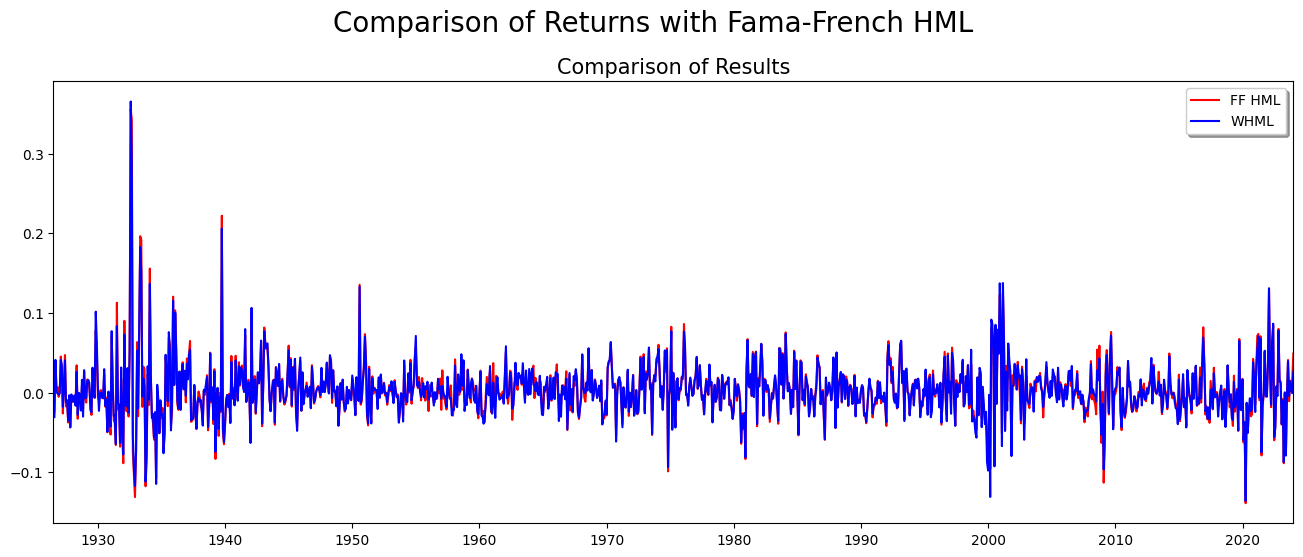

In [85]:
plt.figure(figsize=(16,12))
plt.suptitle('Comparison of Returns with Fama-French HML', fontsize=20)

ax1 = plt.subplot(211)
ax1.set_title('Comparison of Results', fontsize=15)
ax1.set_xlim([dt.datetime(1926,7,1), dt.datetime(2023,12,31)])
ax1.plot(_ffcomp['hml'], 'r-', _ffcomp['WHML'], 'b-')
ax1.legend(('FF HML','WHML'), loc='upper right', shadow=True)

plt.subplots_adjust(top=0.92, hspace=0.2)

plt.show()

In [39]:
_ffcomp["WHML"] = _ffcomp["WHML"].fillna(0)

In [116]:
_ffcomp["cum_hml"] = np.cumprod(1 + _ffcomp['hml'].values) - 1
_ffcomp["cum_WHML"] = np.cumprod(1 + _ffcomp['WHML'].values) - 1

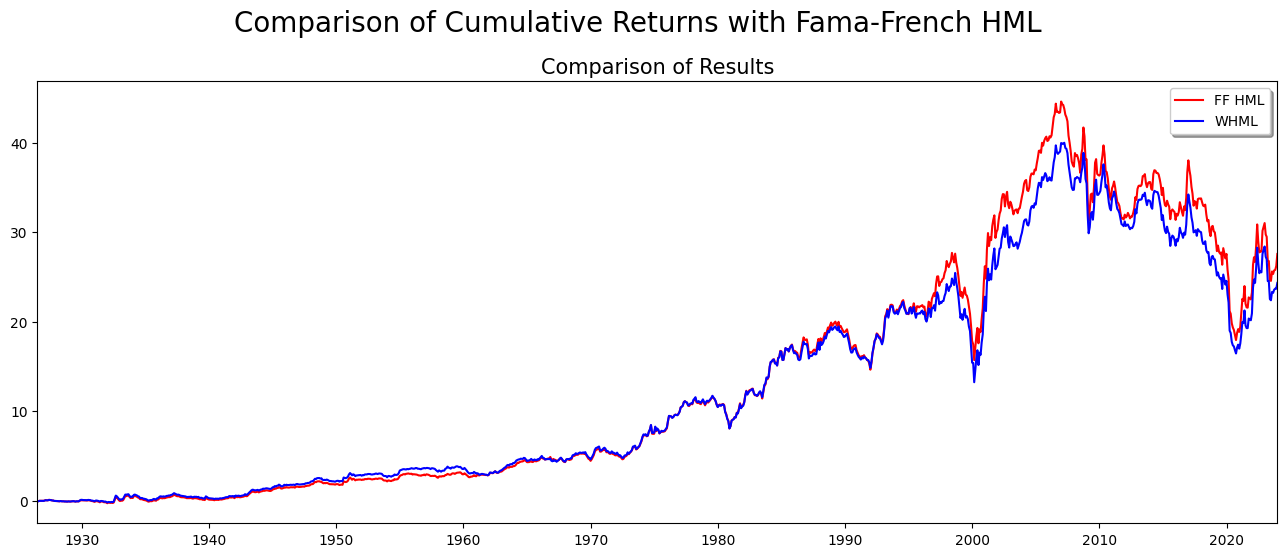

In [86]:
plt.figure(figsize=(16,12))
plt.suptitle('Comparison of Cumulative Returns with Fama-French HML', fontsize=20)

ax1 = plt.subplot(211)
ax1.set_title('Comparison of Results', fontsize=15)
ax1.set_xlim([dt.datetime(1926,7,1), dt.datetime(2023,12,31)])
ax1.plot(_ffcomp['cum_hml'], 'r-', _ffcomp['cum_WHML'], 'b-')
ax1.legend(('FF HML','WHML'), loc='upper right', shadow=True)

plt.subplots_adjust(top=0.92, hspace=0.2)

plt.show()

In [110]:
jkp_factor_equal_weighted = pd.read_csv('[usa]_[be_me]_[monthly]_[ew].csv')
jkp_factor_value_weighted = pd.read_csv('[usa]_[be_me]_[monthly]_[vw].csv')
jkp_factor_capped_value_weighted = pd.read_csv('[usa]_[be_me]_[monthly]_[vw_cap].csv')

In [111]:
jkp_factor_equal_weighted['date'] = pd.to_datetime(jkp_factor_equal_weighted['date'])
jkp_factor_value_weighted['date'] = pd.to_datetime(jkp_factor_value_weighted['date'])
jkp_factor_capped_value_weighted['date'] = pd.to_datetime(jkp_factor_capped_value_weighted['date'])

jkp_factor_equal_weighted.set_index('date', inplace = True)
jkp_factor_value_weighted.set_index('date', inplace = True)
jkp_factor_capped_value_weighted.set_index('date', inplace = True)

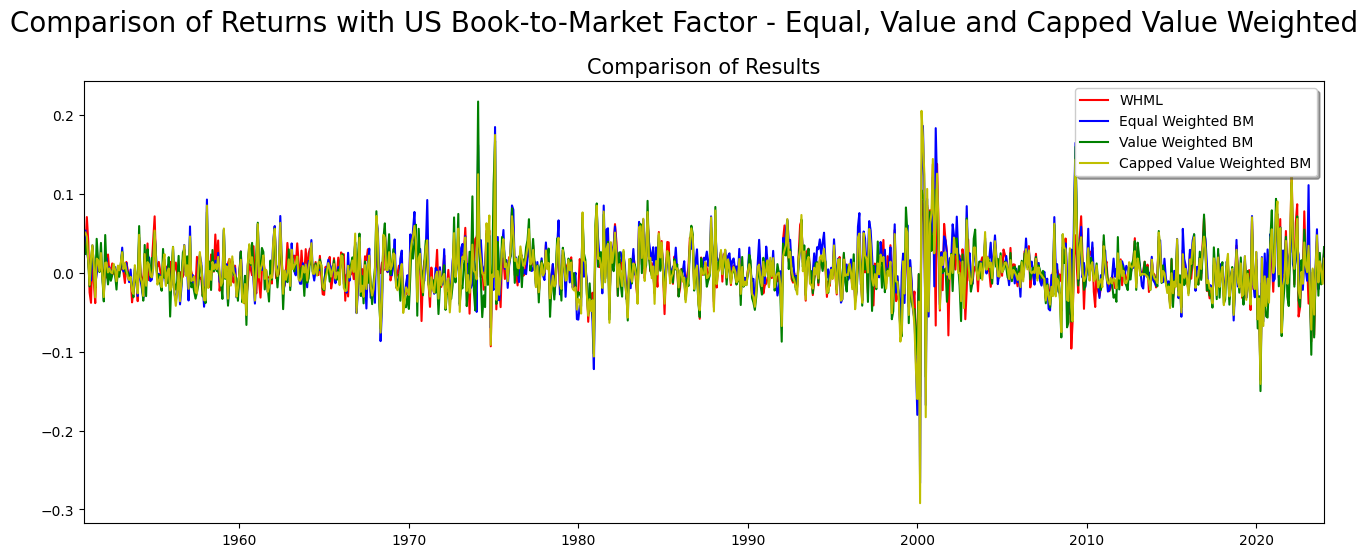

In [112]:
plt.figure(figsize=(16,12))
plt.suptitle('Comparison of Returns with US Book-to-Market Factor - Equal, Value and Capped Value Weighted', fontsize=20)

ax1 = plt.subplot(211)
ax1.set_title('Comparison of Results', fontsize=15)
ax1.set_xlim([dt.datetime(1950,11,1), dt.datetime(2023,12,31)])
ax1.plot(_ffcomp_comparison_subset['WHML'], 'r-', jkp_factor_equal_weighted['ret'], 'b-', jkp_factor_value_weighted['ret'], 'g-', jkp_factor_capped_value_weighted['ret'], 'y-')
ax1.legend(('WHML','Equal Weighted BM', 'Value Weighted BM', 'Capped Value Weighted BM'), loc='upper right', shadow=True)

plt.subplots_adjust(top=0.92, hspace=0.2)

plt.show()

In [113]:
jkp_factor_equal_weighted['cum_ret'] = np.cumprod(1 + jkp_factor_equal_weighted['ret'].values) - 1
jkp_factor_value_weighted['cum_ret'] = np.cumprod(1 + jkp_factor_value_weighted['ret'].values) - 1
jkp_factor_capped_value_weighted['cum_ret'] = np.cumprod(1 + jkp_factor_capped_value_weighted['ret'].values) - 1

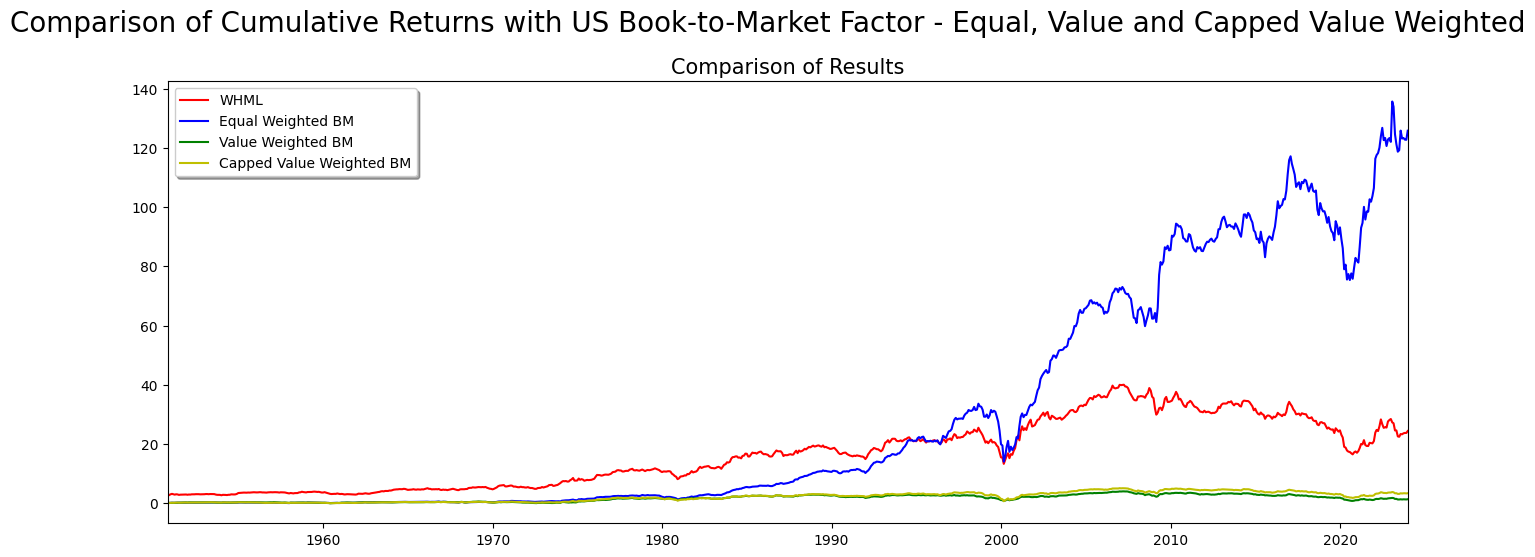

In [114]:
plt.figure(figsize=(16,12))
plt.suptitle('Comparison of Cumulative Returns with US Book-to-Market Factor - Equal, Value and Capped Value Weighted', fontsize=20)

ax1 = plt.subplot(211)
ax1.set_title('Comparison of Results', fontsize=15)
ax1.set_xlim([dt.datetime(1950,11,1), dt.datetime(2023,12,31)])
ax1.plot(_ffcomp_comparison_subset['cum_WHML'], 'r-', jkp_factor_equal_weighted['cum_ret'], 'b-', jkp_factor_value_weighted['cum_ret'], 'g-', jkp_factor_capped_value_weighted['cum_ret'], 'y-')
ax1.legend(('WHML','Equal Weighted BM', 'Value Weighted BM', 'Capped Value Weighted BM'), loc='upper left', shadow=True)

plt.subplots_adjust(top=0.92, hspace=0.2)

plt.show()

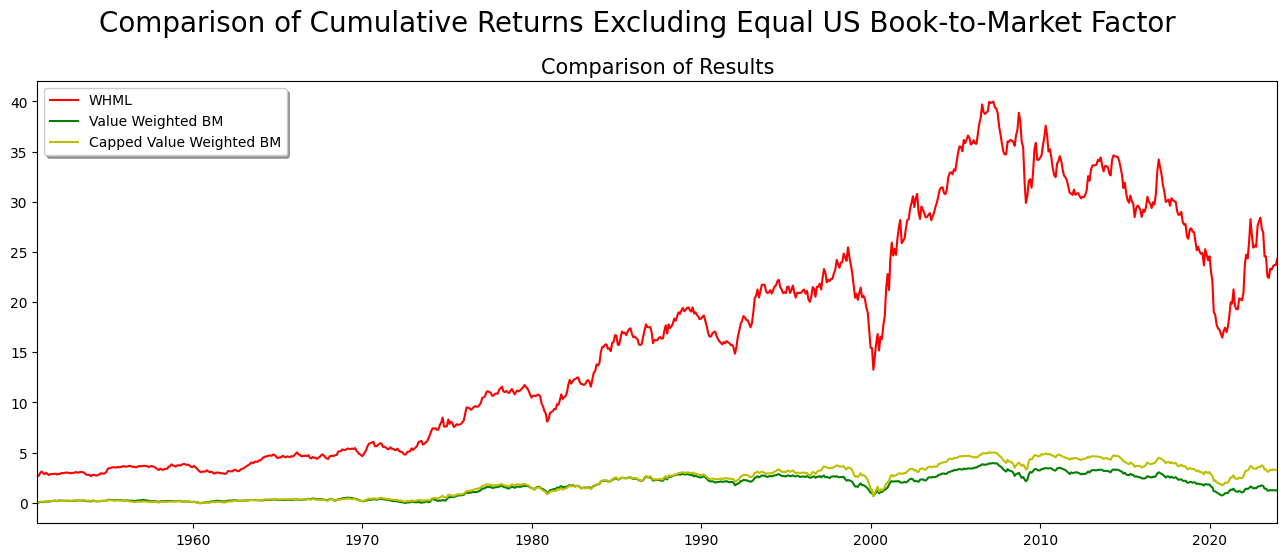

In [115]:
plt.figure(figsize=(16,12))
plt.suptitle('Comparison of Cumulative Returns Excluding Equal US Book-to-Market Factor', fontsize=20)

ax1 = plt.subplot(211)
ax1.set_title('Comparison of Results', fontsize=15)
ax1.set_xlim([dt.datetime(1950,11,1), dt.datetime(2023,12,31)])
ax1.plot(_ffcomp_comparison_subset['cum_WHML'], 'r-', jkp_factor_value_weighted['cum_ret'], 'g-', jkp_factor_capped_value_weighted['cum_ret'], 'y-')
ax1.legend(('WHML', 'Value Weighted BM', 'Capped Value Weighted BM'), loc='upper left', shadow=True)

plt.subplots_adjust(top=0.92, hspace=0.2)

plt.show()